In [1]:
import json
import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
import gensim.models as models
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors
import gensim.downloader as api
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def preprocess(text:str, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if re.match(r'(\d.|\d)', lemma) is None:
                if lemma not in stop_words:
                    preprocessed_text.append(lemma)
    return preprocessed_text

def read_json(path: str):
    file = open(path)
    data = json.load(file)
    return pd.DataFrame(data)

def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(sim.size):
        if df['need_match'][i]:
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

def calc_accuracy(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
    return round(float((TP + TN) / (TP + TN + FP + FN)), 3)


punctuation_marks = ['!', ',', '(', ')', ';', ':', '-', '?', '.', '..', '...', "\"", "/", "\`\`", "»", "«" ]
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [3]:
class ModelResearcher:
    def __init__(self):
        self.model = None
    
    def preprocess_and_save(self, data_df: pd.DataFrame, path, text_field='text') -> pd.DataFrame:
        # for preprocessing dataset. Use it only in critical cases cause it's too slow on big datasets
        data_df['preprocessed_' + text_field] = data_df.apply(lambda row: preprocess(row[text_field], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def preprocess_and_save_pairs(self, data_df: pd.DataFrame, path, text_field_1, text_field_2) -> pd.DataFrame:
        data_df['preprocessed_' + text_field_1] = data_df.apply(lambda row: preprocess(row[text_field_1], punctuation_marks, stop_words, morph), axis=1)
        data_df['preprocessed_' + text_field_2] = data_df.apply(lambda row: preprocess(row[text_field_2], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field_1, text_field_2], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def train(self, data_df: pd.DataFrame, model="w2v"):            
        if model == "w2v":
            train_part = data_df['preprocessed_texts']
            self.model = gensim.models.Word2Vec(sentences=train_part, min_count=5, vector_size=50, epochs=10)
            self.model.save('w2v')
        elif model == "fast_text":
            train_part = data_df['preprocessed_texts'].tolist()
            self.model = gensim.models.FastText(vector_size=50, min_count=5)
            self.model.build_vocab(corpus_iterable=train_part)
            self.model.train(corpus_iterable=train_part, total_examples=len(train_part), epochs=5)
            self.model.save('fastText')
        return

                    
    
    def predict_sentences_similarity(self, sentences_1: pd.Series, sentences_2: pd.Series):
        if sentences_1.size != sentences_2.size:
            return None
        else:
            if self.model is not None:
                sentences_sim = np.zeros(sentences_1.size)
                sz = sentences_1.size
                for i in range(sz): 
                    sentences_1_words = [w for w in sentences_1[i] if w in self.model.wv.index_to_key]
                    sentences_2_words = [w for w in sentences_2[i] if w in self.model.wv.index_to_key]
                    sim = self.model.wv.n_similarity(sentences_1_words, sentences_2_words)
                    sentences_sim[i] = sim
                
                return sentences_sim
            else:
                return None
        
    def get_train_test_dfs_for_f1(self, df_match, df_unmatch): 
        df_match = shuffle(df_match)
        df_unmatch = shuffle(df_unmatch)
        
        df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
        df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
        return (df_train_f1, df_test_f1)
    
    
    def get_optimal_threshold(self, sentences_1: pd.Series, sentences_2: pd.Series, df, step=0.02):
        if sentences_1.size != sentences_2.size or self.model is None:
            return None
        else:
            threshold = 0
            thresholds = []
            max_ = 0
            h = step
            steps = np.linspace(0, 1, num=int(1/h))
            steps = np.round(steps, 2)
            h_max = 0
            sim =  self.predict_sentences_similarity( sentences_1, sentences_2)
            for i in steps:
                threshold = calc_f1_score(sim, df, h)
                print(h, threshold)
                thresholds.append(threshold)
                if threshold > max_:
                    max_ = threshold
                    h_max = h
                h += step
            plt.plot(steps, thresholds)
            plt.figure(figsize=(10,3))
            plt.show()
            
            return h_max

## Обучим word2vec

In [4]:
data_df = read_json('./preprocessed_documents.json')
modelResearcher_w2v = ModelResearcher()
# modelResearcher_w2v.train(data_df, model="w2v")
modelResearcher_w2v.model = models.ldamodel.LdaModel.load('./w2v')
modelResearcher_w2v.model

In [73]:
data_df['preprocessed_texts']

0       [дисциплина, посвятить, изучение, вопрос, связ...
1       [рамка, дисциплина, рассматриваться, метод, ср...
2       [дисциплина, изучаться, математический, метод,...
3       [дисциплина, теория, оптимальный, управление, ...
4       [дисциплина, включать, изложение, основа, теор...
                              ...                        
4728    [it-рекрутер_hr-менеджер, основной, задача, •,...
4729    [анализ, фактор, влиять, посещаемость, музей, ...
4730    [senior, middle, java, находиться, поиск, seni...
4731    [python, разработчик, находиться, поиск, pytho...
4732    [чёрт-стажёр, страх, ужас, нужный, чёрт, демон...
Name: preprocessed_texts, Length: 4733, dtype: object

In [5]:
# match_unmatch_df = read_json('./dataset.json')

In [6]:
df_match = read_json('./data/match.json')[:-2]
df_unmatch = read_json('./data/unmatch.json')

In [19]:
import json 
df_match.iloc[2].to_dict()

{'id_rp': '1009',
 'id_proj': '4',
 'name_rp': 'РАЗРАБОТКА ПРИЛОЖЕНИЙ В РАСПРЕДЕЛЕННОЙ СРЕДЕ',
 'name_proj': 'Разработка модулей обработки данных для библиотеки алгоритмов федеративного обучения FL4J ',
 'text_rp': 'Дисциплина посвящена изучению основных принципов распределённых систем. В теоретической части курса рассматриваются вопросы о взаимодействии и синхронизации процессов, достижении непротиворечивости реплицируемых данных, обеспечении отказоустойчивости в распределенных системах. В процессе освоения дисциплины формируются практические навыки разработки распределенных приложений на объектно-ориентированном языке программирования Java с использованием различных моделей взаимодействия процессов. . Целью дисциплины является изучение принципов распределённых систем и формирование практических навыков разработки распределенных приложений с использованием различных моделей взаимодействия процессов. Получение теоретических знаний в области взаимодействия и синхронизации процессов, дос

In [18]:
len(df_match)

35

In [77]:
df_train_f1, df_test_f1 = modelResearcher_w2v.get_train_test_dfs_for_f1(df_match, df_unmatch)

In [78]:
# print('df_train: {} of {}'.format(df_train_f1['id_rp'].size, match_unmatch_df ['id_rp'].size))
# print('df_test: {} of {}'.format(df_test_f1['id_rp'].size,match_unmatch_df['id_rp'].size))

In [79]:
df_train_f1 = modelResearcher_w2v.preprocess_and_save_pairs(df_train_f1, None, 'text_rp', 'text_proj')
df_test_f1 = modelResearcher_w2v.preprocess_and_save_pairs(df_test_f1, None, 'text_rp', 'text_proj')

In [80]:
result_w2v_train = modelResearcher_w2v.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
print(result_w2v_train)

[0.43783876 0.78563374 0.61523765 0.85213083 0.46187714 0.76616025
 0.57451683 0.84332138 0.80015588 0.57313359 0.73210019 0.8607533
 0.70850456 0.90276861 0.8862173  0.87649679 0.88589334 0.37826762
 0.46044144 0.4197768  0.61669093 0.74201459 0.33040631 0.80667573
 0.23390482 0.5330922  0.50997144 0.00562475 0.47497338 0.57371163
 0.70036554 0.6825856  0.51717567 0.62059015]


0.02 0.68
0.04 0.68
0.06 0.68
0.08 0.68
0.1 0.68
0.12000000000000001 0.68
0.14 0.68
0.16 0.68
0.18 0.68
0.19999999999999998 0.68
0.21999999999999997 0.68
0.23999999999999996 0.694
0.25999999999999995 0.694
0.27999999999999997 0.694
0.3 0.694
0.32 0.694
0.34 0.708
0.36000000000000004 0.708
0.38000000000000006 0.723
0.4000000000000001 0.723
0.4200000000000001 0.739
0.4400000000000001 0.711
0.46000000000000013 0.711
0.48000000000000015 0.714
0.5000000000000001 0.714
0.5200000000000001 0.75
0.5400000000000001 0.769
0.5600000000000002 0.769
0.5800000000000002 0.722
0.6000000000000002 0.722
0.6200000000000002 0.706
0.6400000000000002 0.727
0.6600000000000003 0.727
0.6800000000000003 0.727
0.7000000000000003 0.75
0.7200000000000003 0.733
0.7400000000000003 0.69
0.7600000000000003 0.714
0.7800000000000004 0.667
0.8000000000000004 0.615
0.8200000000000004 0.583
0.8400000000000004 0.583
0.8600000000000004 0.455
0.8800000000000004 0.3
0.9000000000000005 0.111
0.9200000000000005 0.0
0.940000000000

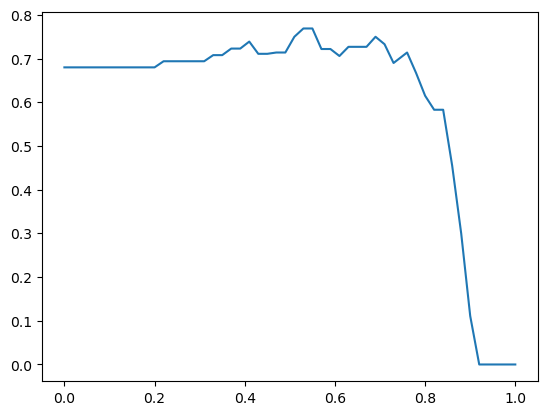

<Figure size 1000x300 with 0 Axes>

In [81]:
result_w2v_train_opt = modelResearcher_w2v.get_optimal_threshold(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'], df_train_f1, 0.02)

In [82]:
print(result_w2v_train_opt)

0.5400000000000001


In [83]:
f1_w2v_train = calc_f1_score(result_w2v_train, df_train_f1, result_w2v_train_opt)
acc_w2v_train = calc_accuracy(result_w2v_train, df_train_f1, result_w2v_train_opt)
print('F1-score train w2v: {}'.format(f1_w2v_train ))
print('accuracy train w2v: {}'.format(acc_w2v_train))
df_train_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_train_f1.insert(loc=4, column='score', value=result_w2v_train) 
# df_train_f1

F1-score train w2v: 0.769
accuracy train w2v: 0.735


In [84]:
result_w2v_test = modelResearcher_w2v.predict_sentences_similarity(df_test_f1['preprocessed_text_rp'], df_test_f1['preprocessed_text_proj'])
f1_w2v_test = calc_f1_score(result_w2v_test, df_test_f1, result_w2v_train_opt)
acc_w2v_test = calc_accuracy(result_w2v_test, df_test_f1, result_w2v_train_opt)
print('F1-score test w2v: {}'.format(f1_w2v_test))
print('accuracy test w2v: {}'.format(acc_w2v_test))

F1-score test w2v: 0.75
accuracy test w2v: 0.667


In [85]:
df_test_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_test_f1.insert(loc=4, column='score', value=result_w2v_test) 
df_test_f1[8:]

,id_rp,id_proj,name_rp,name_proj,score,need_match,preprocessed_text_rp,preprocessed_text_proj
8,1000,15,АЛГОРИТМЫ БЕСПИЛОТНОГО ТРАНСПОРТА,Разработка системы движения роя дронов в прост...,0.801327,True,"[данный, курс, знакомить, слушатель, основа, у...","[разработка, система, движение, рой, дрон, про..."
9,1916,41,Разработка программного обеспечения для робот...,Разработка подводного телеуправляемого робота ...,0.797273,True,"[цель, изучение, курс, состоять, формирование,...","[разработка, подводный, телеуправляемый, робот..."
10,1009,4,РАЗРАБОТКА ПРИЛОЖЕНИЙ В РАСПРЕДЕЛЕННОЙ СРЕДЕ,Разработка модулей обработки данных для библио...,0.718113,True,"[дисциплина, посвятить, изучение, основный, пр...","[разработка, модуль, обработка, данные, библио..."
11,8010,8011,Интеллектуальные технологии управления рисками,руководитель отдела международной лингвистики ...,0.835715,True,"[дисциплина, предназначить, подготовка, специа...","[торгово-промышленный, группа, тайпит, приглаш..."
12,8008,8009,Семантические технологии и многоагентные системы,Проект открытой семантической технологии компо...,0.917686,True,"[дисциплина, включать, изучение, основный, мод...","[работа, рассматриваться, открытый, проект, на..."
13,1040,26,Управление и информатика в технических системах,Программно-аппаратное конфигурирование сети ла...,0.735219,True,"[рамка, дать, дисциплина, рассматриваться, осн...","[программно-аппаратный, конфигурирование, сеть..."
14,5089,31,Глубокое обучение,Определение состояния автомобиля используя видео,0.829041,True,"[глубокий, обучение, являться, передовой, обла...","[определение, состояние, автомобиль, использов..."
15,4530,4999,Информационные технологии проектирования радио...,Инженер,0.733255,True,"[цель, изучение, дисциплина, являться, приобре...","[обязанность, участие, приёмо-сдаточный, испыт..."
16,985,8,Основы компьютерного дизайна,"Разработка ИС ""Расписание"" / ""Деканат"".",0.603140,True,"[курс, рассматриваться, свойство, зрительный, ...","[разработка, иса, ``, расписание, '', ``, дека..."
17,8006,8007,Беспроводные сети,Инженер беспроводных сетей,0.781181,True,"[курс, изучаться, общий, вопрос, история, перс...","[cti, communication, technology, innovations, ..."


## Leave One Out

In [86]:
def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)
    
def max_f1_score(sim, df):
    threshold = 0
    thresholds = []
    max_ = 0
    step_max_ = 0
    step = 0.02
    h = step
    steps = np.linspace(0, 1, num=int(1/h))
    steps = np.round(steps, 2)

    for i in steps:
        threshold = calc_f1_score(sim, df, h)
        thresholds.append(threshold)
        if threshold > max_:
            max_ = threshold
            step_max_ = h
        h += step
    
    return (steps, thresholds, max_, step_max_)

In [87]:
df_train_f1 = read_json('./data/all_examples.json')
df_train_f1 = modelResearcher_w2v.preprocess_and_save_pairs(df_train_f1, None, 'text_rp', 'text_proj')

In [89]:
N = len(df_train_f1)


sim = modelResearcher_w2v.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
sim = list(sim)
predictions = []
for i in range(N):
    current_df = df_train_f1.drop(i).reset_index().drop(labels='index', axis=1)
    current_sim = sim[:i] + sim[i+1:]
    steps, thresholds, max_, cutoff = max_f1_score(current_sim, current_df)
    print(max_, cutoff)
    if sim[i] >= cutoff:
      predictions.append(True)
    else:
      predictions.append(False)

0.8 0.7000000000000003
0.8 0.7000000000000003
0.817 0.7200000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.817 0.7200000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.817 0.7200000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.817 0.7200000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.817 0.7200000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.817 0.7200000000000003
0.8 0.7000000000000003
0.817 0.7200000000000003
0.817 0.7200000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.8 0.7000000000000003
0.806 0.7200000000000003
0.806 0.7200000000000003
0.806 0.7200000000000003
0.806 0.7200000000000003
0.806 0.7200000000000003
0.806 0.

In [90]:
def get_states_leave_one_out(predictions, df):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if predictions[i]: 
                TP += 1
            else:
                FN += 1
        else:
            if predictions[i]: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score_loo(calc_states):
    (TP, FP, FN, TN) = calc_states()
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

In [92]:
calc_f1_score_loo(lambda: get_states_leave_one_out(predictions, df_train_f1))

0.773

## FastText

In [ ]:
# modelResearcher_ft = ModelResearcher()
data_df = read_json('./preprocessed_documents.json')
# modelResearcher_ft.train(data_df, model="fast_text")


In [ ]:
modelResearcher_ft = ModelResearcher()
modelResearcher_ft.model = models.ldamodel.LdaModel.load('ft')

0.02 0.667
0.04 0.667
0.06 0.667
0.08 0.667
0.1 0.667
0.12000000000000001 0.667
0.14 0.667
0.16 0.667
0.18 0.667
0.19999999999999998 0.667
0.21999999999999997 0.667
0.23999999999999996 0.667
0.25999999999999995 0.667
0.27999999999999997 0.667
0.3 0.667
0.32 0.667
0.34 0.667
0.36000000000000004 0.667
0.38000000000000006 0.667
0.4000000000000001 0.667
0.4200000000000001 0.667
0.4400000000000001 0.667
0.46000000000000013 0.667
0.48000000000000015 0.667
0.5000000000000001 0.667
0.5200000000000001 0.667
0.5400000000000001 0.688
0.5600000000000002 0.688
0.5800000000000002 0.688
0.6000000000000002 0.688
0.6200000000000002 0.688
0.6400000000000002 0.688
0.6600000000000003 0.71
0.6800000000000003 0.733
0.7000000000000003 0.733
0.7200000000000003 0.786
0.7400000000000003 0.769
0.7600000000000003 0.769
0.7800000000000004 0.72
0.8000000000000004 0.75
0.8200000000000004 0.9
0.8400000000000004 0.778
0.8600000000000004 0.625
0.8800000000000004 0.429
0.9000000000000005 0.308
0.9200000000000005 0.308
0

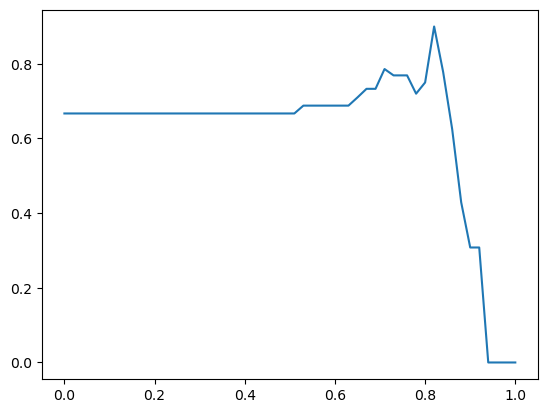

<Figure size 1000x300 with 0 Axes>

In [ ]:
result_ft_train_opt = modelResearcher_ft.get_optimal_threshold(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'], df_train_f1, 0.02)

In [ ]:
print(result_ft_train_opt)

0.8200000000000004


In [ ]:
result_ft_train = modelResearcher_ft.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
f1_ft_train = calc_f1_score(result_ft_train, df_train_f1, result_ft_train_opt)
acc_ft_train = calc_accuracy(result_ft_train, df_train_f1, result_ft_train_opt)
print('F1-score train ft: {}'.format(f1_ft_train ))
print('accuracy train ft: {}'.format(acc_ft_train ))
df_train_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_train_f1.insert(loc=4, column='score', value=result_ft_train) 

F1-score train ft: 0.9
accuracy train ft: 0.909


In [ ]:
result_ft_test = modelResearcher_ft.predict_sentences_similarity(df_test_f1['preprocessed_text_rp'], df_test_f1['preprocessed_text_proj'])
f1_ft_test = calc_f1_score(result_ft_test, df_test_f1, result_ft_train_opt)
acc_ft_test = calc_accuracy(result_ft_test, df_test_f1, result_ft_train_opt)
print('F1-score test ft: {}'.format(f1_ft_test))
print('accuracy test ft: {}'.format(acc_ft_test ))
df_test_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_test_f1.insert(loc=4, column='score', value=result_ft_test) 

F1-score test ft: 0.727
accuracy test ft: 0.727


In [ ]:
N = len(df_train_f1)

sim = modelResearcher_ft.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
sim = list(sim)
predictionsf = []
for i in range(N):
    current_df = df_train_f1.drop(i).reset_index().drop(labels='index', axis=1)
    current_sim = sim[:i] + sim[i+1:]
    steps, thresholds, max_, cutoff = max_f1_score(current_sim, current_df)
    print(max_, cutoff)
    if sim[i] >= cutoff:
      predictionsf.append(True)
    else:
      predictionsf.append(False)

print(predictionsf)

0.947 0.8200000000000004
0.889 0.8200000000000004
0.889 0.8200000000000004
0.947 0.8200000000000004
0.889 0.8200000000000004
0.889 0.8200000000000004
0.889 0.8200000000000004
0.889 0.8200000000000004
0.889 0.8200000000000004
0.889 0.8200000000000004
0.889 0.8200000000000004
0.9 0.8200000000000004
0.9 0.8200000000000004
0.9 0.8200000000000004
0.9 0.8200000000000004
0.9 0.8200000000000004
0.9 0.8200000000000004
0.9 0.8200000000000004
0.9 0.8200000000000004
0.9 0.8200000000000004
0.9 0.8200000000000004
0.9 0.8200000000000004
[False, True, True, False, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False]


In [ ]:
calc_f1_score_loo(lambda: get_states_leave_one_out(predictionsf, df_train_f1))

0.9